# Analyizing movie topics to select optimum release data for Maze Runner

## Read in data
### 1) topics_allmovies.csv contains the topic distribution of movies from an LDA analysis of movie reviews

In [129]:
import pandas as pd

topics_allmovies = pd.read_csv('topics_allmovies.csv')

#add title column header
headers = list(topics_allmovies.columns)
headers[0] ='Title'
topics_allmovies.columns = headers
print(topics_allmovies.head())

                           Title   odid    Topic1    Topic2    Topic3  \
0                        Titanic  10100  0.067890  0.023853  0.012844   
1                The Dark Knight  20100  0.754413  0.006140  0.005372   
2         Star Wars Ep. I: The P  60100  0.015385  0.017949  0.017949   
3  Pirates of the Caribbe (2006)  70100  0.026667  0.036667  0.073333   
4          Transformers: Revenge  90100  0.039801  0.034826  0.034826   

     Topic4    Topic5    Topic6    Topic7    Topic8    Topic9   Topic10  
0  0.012844  0.016514  0.012844  0.012844  0.033028  0.796330  0.011009  
1  0.006907  0.004605  0.203377  0.004605  0.006140  0.004605  0.003837  
2  0.558974  0.276923  0.035897  0.033333  0.017949  0.012821  0.012821  
3  0.046667  0.040000  0.016667  0.663333  0.016667  0.020000  0.060000  
4  0.054726  0.606965  0.059701  0.029851  0.049751  0.024876  0.064677  


### 2) opus_movies.txt contains various information for each movie (release date, production cost,....

In [130]:
# fileText = None
# with open('opus_movies.txt') as file:
#     fileText = file.read()

    
# for line in fileText.split('\n'):
#     print(line)

movieInfo = pd.read_csv('opus_movies.csv')
print(movieInfo.head())


    odid                                display_name release_date  \
0  10100                                     Titanic     4/4/2012   
1  20100                             The Dark Knight    7/18/2008   
2  60100         Star Wars Ep. I: The Phantom Menace    2/10/2012   
3  70100  Pirates of the Caribbean: Dead Man's Chest     7/7/2006   
4  90100         Transformers: Revenge of the Fallen    6/24/2009   

  release_pattern         distributor  \
0            Wide  Paramount Pictures   
1            Wide        Warner Bros.   
2            Wide    20th Century Fox   
3            Wide         Walt Disney   
4            Wide  Paramount Pictures   

                                  movie_url  production_year  running_time  \
0                                   Titanic             1997         194.0   
1                           Dark-Knight-The             2008         152.0   
2         Star-Wars-Ep-I-The-Phantom-Menace             1999         133.0   
3  Pirates-of-the-Caribbea

## Measure similarity between Maze Runner and other movies using Euclidean distance

In [133]:
import numpy as np
import matplotlib.pyplot as plt

#convert to numpy arrays
movieTitles = np.array(topics_allmovies['Title'])
print(movieTitles.shape)
movieOdid = np.array(topics_allmovies['odid'])
print(movieTitles.shape)
movieTopics = np.array(topics_allmovies[list(topics_allmovies.columns)[2:12]])
print(movieTopics.shape)


#remove maze runner from both arrays and get Topics
mazeRunnerTopics = movieTopics[movieTitles == 'The Maze Runner']
movieTopics = movieTopics[movieTitles != 'The Maze Runner']
movieTitles = movieTitles[movieTitles != 'The Maze Runner']

print(mazeRunnerTopics.shape)
print(movieTopics.shape)
print(movieTitles.shape)

#create distance array for distance between MR and other movies
distances = [np.linalg.norm(topics - mazeRunnerTopics) for topics in movieTopics]

#find most related movies using smallest distances
sortedDistances = np.argsort(distances)

#print top five movie titles
print('*** 5 most similar movies ***')
for i in range(5):
    print('\t', movieTitles[sortedDistances[i]])


(1153,)
(1153,)
(1153, 10)
(1, 10)
(1152, 10)
(1152,)
*** 5 most similar movies ***
	 The Twilight Saga: New
	 Daybreakers
	 28 Weeks Later
	 The Conjuring
	 Underworld: Evolution


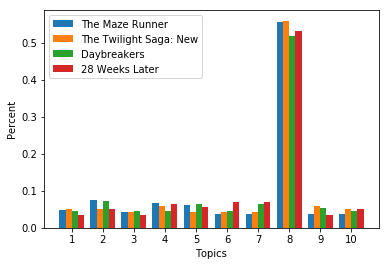

In [132]:
#print bar chart comparing movie topics

#attach other movie topics
MRandTop3 = movieTopics[sortedDistances[0:3]]
graphLabels = [movieTitles[movIdx] for movIdx in sortedDistances[0:3]]


#attach MR topics
MRandTop3 = np.vstack([mazeRunnerTopics, MRandTop3])
graphLabels.insert(0,'The Maze Runner')
graphLabels = np.array(graphLabels)

X = np.arange(1,11)

def subcategorybar(X, vals, labels, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    ax = None
    for i in range(n):
        #print(labels[i])
        #print(len(labels))
        ax = plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge", label = labels[i])   
    plt.xticks(_X, X)
    plt.legend()
    plt.xlabel('Topics')
    plt.ylabel('Percent')
    plt.show()
    

subcategorybar(X, MRandTop3, graphLabels)



## Find optimal data to release in 2014

### Score days within 2014 using the similarity of movies being released around that date

    Higher scores for dates with higher similarity movies being released
    
    Use decaying function to approximate the draw of movies over time
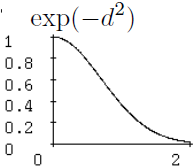

In [128]:
from datetime import datetime
dateString = '4/4/2012'

datetime_object = datetime.strptime('2018-10-15 20:59:29', '%Y-%m-%d %H:%M:%S')
datetime_object = datetime.strptime(dateString, '%m/%d/%Y')

print(datetime_object)
print(int(datetime_object.strftime("%j")))

2012-04-04 00:00:00
95


### Score dates by historical gross revenue for movies similar (same Genre) to "The Maze Runner"
    
    use movie production cost and rating to normalize

In [ ]:
#create scatter plot with dayOfYear and profitability